In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, mean_squared_error

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report



In [ ]:
file = 'Datasets/diabetes_BRFSS2015/diabetes_012_health_indicators_BRFSS2015.csv'
df = pd.read_csv(file)
df

In [ ]:
df.columns = df.columns.str.lower().str.replace('_012','')

In [ ]:
df.columns

In [ ]:
df.info()

### Tree

In [ ]:
def getRandomDF(df, value, n, state):
    return df[df.diabetes==value].sample(n=n, random_state=state)

In [ ]:
dfs = {}
size = df.diabetes.value_counts()[1.0]

# Data for diabetes == 1
df1 = df[df.diabetes==1].sample(n=size)

# Get 10 random balanced dataframes. 
# The most imbalanced class (1) determines the total number of samples 4,361 * 3 = 13,893
for i in range(0,10):
    df0 = getRandomDF(df, 0, size, i)
    #df2 = getRandomDF(df, 2, size, i)
    dfs[i] = pd.concat([df0, df1])

In [ ]:
for i,j in dfs.items():
    model = make_pipeline(DecisionTreeClassifier(max_depth=10))
    
    target = j.diabetes
    data = j.drop(columns=['diabetes'])
    
    dfTrainFull, dfTest, yTrainFull, yTest = train_test_split(data, target, test_size=0.2, random_state=i)
    dfTrain, dfVal, yTrain, yVal = train_test_split(data, target, test_size=0.25, random_state=i)
    model.fit(dfTrain, yTrain)
    resdfVal = model.predict_proba(dfVal)#[:,1]
    yValPred = np.argmax(resdfVal, axis=1)
    print(f'Val prediction: {yValPred}')
    print(f'Val RMSE: {mean_squared_error(yVal, yValPred,squared=False)}')

    resdfValPred = model.predict_proba(dfTrain)#[:,1]
    yTrainPred = np.argmax(resdfValPred, axis=1)
    print(f'Train prediction: {yTrainPred}')
    print(f'Val RMSE: {mean_squared_error(yTrain, yTrainPred,squared=False)}')
    
    cm = confusion_matrix(yVal, yValPred)
    cmprob = np.round(100 * cm / len(yVal), 1)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=['0', '1']).plot()
    cm_display = ConfusionMatrixDisplay(cmprob, display_labels=['0', '1']).plot()
    
    print(classification_report(yVal, yValPred))

In [ ]:
for param in model.get_params():
    print(param)

In [14]:

model = make_pipeline(DecisionTreeClassifier())
    

In [ ]:
dfTrainFull, dfTest, yTrainFull, yTest = train_test_split(data, target, test_size=0.2, random_state=11)
dfTrain, dfVal, yTrain, yVal = train_test_split(data, target, test_size=0.25, random_state=11)

In [41]:
categoricalCols = ['highbp', 'highchol', 'cholcheck','smoker',
       'stroke', 'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies',
       'hvyalcoholconsump', 'anyhealthcare', 'nodocbccost', 'genhlth','diffwalk', 'sex', 'education']

numericalCols = ['bmi', 'menthlth', 'physhlth', 'income']

In [ ]:
# creating preprocesors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
catPreprocessor = OneHotEncoder(handle_unknown="ignore")
numPreprocessor = StandardScaler()

# Transforming the data
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ('one-hot-encoder', catPreprocessor, categoricalCols)],remainder="passthrough")
    #('one-hot-encoder', catPreprocessor, categoricalCols),
    #('standard_scaler', numPreprocessor, numericalCols)])
    


In [16]:
# creating the model
from sklearn.pipeline import make_pipeline
#model = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=10, max_leaf_nodes=30))
model = make_pipeline(DecisionTreeClassifier(max_depth=10, max_leaf_nodes=30))


model.fit(dfTrain, yTrain)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, max_leaf_nodes=30))])

In [18]:
resdfVal = model.predict_proba(dfVal)#[:,1]
yValPred = np.argmax(resdfVal, axis=1)
print(f'Val prediction: {yValPred}')
print(f'Val RMSE: {mean_squared_error(yVal, yValPred,squared=False)}')

resdfValPred = model.predict_proba(dfTrain)#[:,1]
yTrainPred = np.argmax(resdfValPred, axis=1)
print(f'Train prediction: {yTrainPred}')
print(f'Val RMSE: {mean_squared_error(yTrain, yTrainPred,squared=False)}')

Val prediction: [0 0 0 ... 0 0 0]
Val RMSE: 0.3724381640771786
Train prediction: [0 0 0 ... 0 0 0]
Val RMSE: 0.36606125300895115


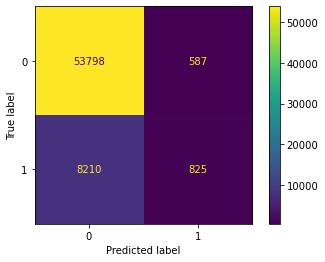

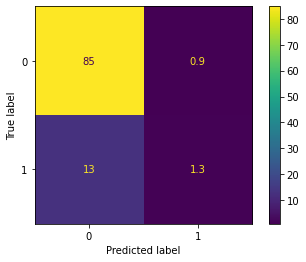

In [20]:
cm = confusion_matrix(yVal, yValPred)
cmprob = np.round(100 * cm / len(yVal), 1)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['0', '1']).plot()
cm_display = ConfusionMatrixDisplay(cmprob, display_labels=['0', '1']).plot()
#tn, fp, fn, tp = cm.ravel()
#print(tn, fp, fn, tp)
#print(cm)

In [21]:
print(classification_report(yVal, yValPred))

              precision    recall  f1-score   support

         0.0       0.87      0.99      0.92     54385
         1.0       0.58      0.09      0.16      9035

    accuracy                           0.86     63420
   macro avg       0.73      0.54      0.54     63420
weighted avg       0.83      0.86      0.82     63420



<AxesSubplot:>

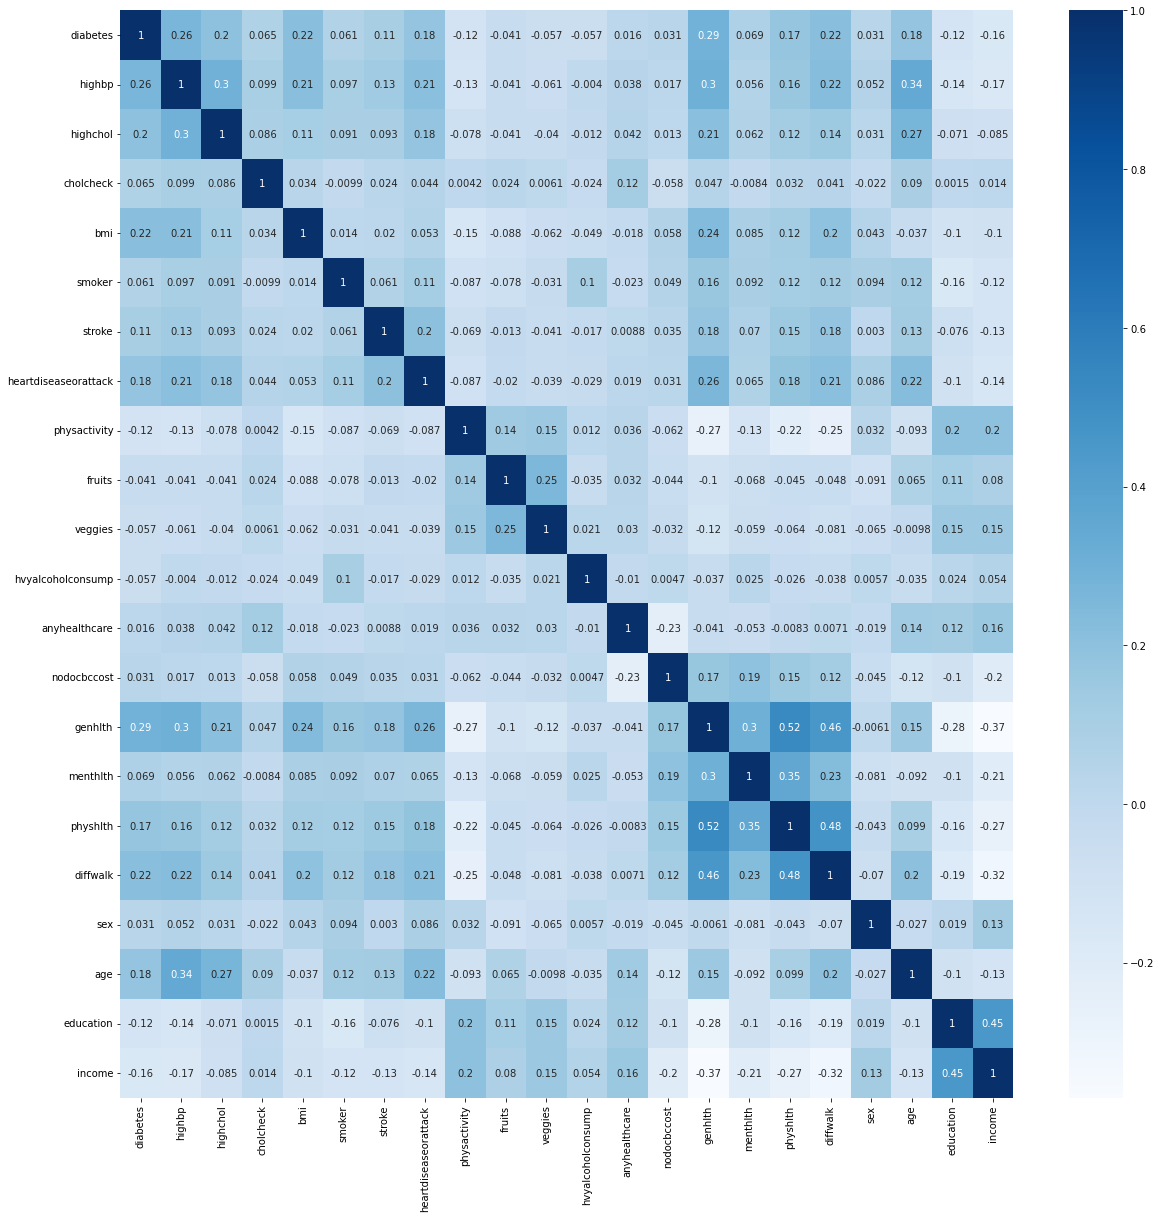

In [22]:
import seaborn as sns
corr = df.corr()
#sns.set_theme()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap="Blues", annot=True)

In [23]:
corr = df[numericalCols + ['diabetes']].corr()
#sns.set_theme()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap="Blues", annot=True)

NameError: name 'numericalCols' is not defined

### Binary

In [24]:
file = 'Datasets/diabetes_binary_health_indicators_BRFSS2015.csv'
df = pd.read_csv(file)
df

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0


In [25]:
df.columns = df.columns.str.lower().str.replace('diabetes_binary','diabetes')
df.columns

Index(['diabetes', 'highbp', 'highchol', 'cholcheck', 'bmi', 'smoker',
       'stroke', 'heartdiseaseorattack', 'physactivity', 'fruits', 'veggies',
       'hvyalcoholconsump', 'anyhealthcare', 'nodocbccost', 'genhlth',
       'menthlth', 'physhlth', 'diffwalk', 'sex', 'age', 'education',
       'income'],
      dtype='object')

In [26]:
target = df.diabetes
data = df.drop(columns=['diabetes'])

In [27]:
dfTrainFull, dfTest, yTrainFull, yTest = train_test_split(data, target, test_size=0.2, random_state=11)
dfTrain, dfVal, yTrain, yVal = train_test_split(data, target, test_size=0.25, random_state=11)

In [28]:
# creating the model
from sklearn.pipeline import make_pipeline
model = make_pipeline(DecisionTreeClassifier(max_depth=10, max_leaf_nodes=30))

model.fit(dfTrain, yTrain)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, max_leaf_nodes=30))])

In [29]:

yValPred = model.predict(dfVal)
print(f'Val prediction: {yValPred}')
print(f'Val RMSE: {mean_squared_error(yVal, yValPred,squared=False)}')
auc = roc_auc_score(yVal, yValPred)
print(auc)

yTrainPred = model.predict(dfTrain)
print(f'Train prediction: {yTrainPred}')
print(f'Val RMSE: {mean_squared_error(yTrain, yTrainPred,squared=False)}')
auc = roc_auc_score(yTrain, yTrainPred)
print(auc)


Val prediction: [0. 0. 0. ... 0. 0. 0.]
Val RMSE: 0.3724381640771786
0.5402590744145725
Train prediction: [0. 0. 0. ... 0. 0. 0.]
Val RMSE: 0.36606125300895115
0.5423569494115171


In [30]:
yValPred

array([0., 0., 0., ..., 0., 0., 0.])

In [31]:
print(classification_report(yVal, yValPred))

              precision    recall  f1-score   support

         0.0       0.87      0.99      0.92     54385
         1.0       0.58      0.09      0.16      9035

    accuracy                           0.86     63420
   macro avg       0.73      0.54      0.54     63420
weighted avg       0.83      0.86      0.82     63420



In [32]:
yValPred = model.predict_proba(dfVal)#[:,1]
yValPred

array([[0.93265007, 0.06734993],
       [0.80784395, 0.19215605],
       [0.67728108, 0.32271892],
       ...,
       [0.94084592, 0.05915408],
       [0.98234   , 0.01766   ],
       [0.54018018, 0.45981982]])

In [33]:
roc_auc_score(yVal,yValPred[:,1])

0.7996756487074186

### Logistic Regression

In [43]:
model = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))    

In [44]:
model.fit(dfTrain, yTrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['highbp', 'highchol',
                                                   'cholcheck', 'smoker',
                                                   'stroke',
                                                   'heartdiseaseorattack',
                                                   'physactivity', 'fruits',
                                                   'veggies',
                                                   'hvyalcoholconsump',
                                                   'anyhealthcare',
                                                   'nodocbccost', 'genhlth',
                                                   'diffwalk', 'sex',
                                                   'education'])])),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [45]:
yValPred = model.predict(dfVal)
print(f'Val prediction: {yValPred}')
print(f'Val RMSE: {mean_squared_error(yVal, yValPred,squared=False)}')
auc = roc_auc_score(yVal, yValPred)
print(auc)

yTrainPred = model.predict(dfTrain)
print(f'Train prediction: {yTrainPred}')
print(f'Val RMSE: {mean_squared_error(yTrain, yTrainPred,squared=False)}')
auc = roc_auc_score(yTrain, yTrainPred)
print(auc)

Val prediction: [0. 0. 0. ... 0. 0. 0.]
Val RMSE: 0.37309380972433726
0.5628166520043842
Train prediction: [0. 0. 0. ... 0. 0. 0.]
Val RMSE: 0.36690740642012876
0.5653533417583216


In [46]:
print(classification_report(yVal, yValPred))

              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92     54385
         1.0       0.54      0.15      0.23      9035

    accuracy                           0.86     63420
   macro avg       0.71      0.56      0.58     63420
weighted avg       0.83      0.86      0.82     63420



In [47]:
roc_auc_score(yVal,yValPred)

0.5628166520043842

In [42]:
# creating preprocesors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
catPreprocessor = OneHotEncoder(handle_unknown="ignore")
numPreprocessor = StandardScaler()

# Transforming the data
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ('one-hot-encoder', catPreprocessor, categoricalCols)],remainder="passthrough")
    #('one-hot-encoder', catPreprocessor, categoricalCols),
    #('standard_scaler', numPreprocessor, numericalCols)])
    


In [ ]:
# creating the model
from sklearn.pipeline import make_pipeline
model = make_pipeline(preprocessor, DecisionTreeClassifier(max_depth=10, max_leaf_nodes=30))

model.fit(dfTrain, yTrain)